# Data Science in Practice 2020

## Problem Set 2

### Descriptive report

Authors :
- Rayan Chaouche
- Yann Martinson
- Christopher Padovani
- Jules Triomphe

### 1. Initialization

#### 1.1 Primary analysis

Loading modules :

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import log_loss, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import time
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import pyplot
from operator import itemgetter, attrgetter
from scipy.stats import randint as sp_randint
from sklearn import metrics

## Functions

In [4]:
def df_preprocessing() :
    
    df_raw = pd.read_csv('customers.csv')
    
    # clean up lines
    
    total_length = len(df_raw)
    df_raw = df_raw[df_raw['TotalCharges'] != ' ']
    df_raw.TotalCharges = df_raw.TotalCharges.astype('float')
    cleanup_length = len(df_raw)
    print('%s lines were deleted.' %(total_length - cleanup_length))
    
    # output into dummies
    
    churn_dummy_dict = {'Yes': 1, 'No': 0}
    df_raw.Churn.replace(churn_dummy_dict, inplace = True)
    
    # X y splitting
    
    y = df_raw.Churn.copy()
    X_raw = df_raw.drop(columns ='Churn').copy()
    
    # input into dummies
    
    X_raw_types = dict(X_raw.dtypes)
    features = list(X_raw.columns)
    categorical_features = [feat for feat in features if X_raw_types[feat] == 'O']
    categorical_features.remove('customerID')
    
    X = pd.get_dummies(X_raw, columns = categorical_features,prefix_sep=':')
    X = X.drop(columns = 'customerID').copy()
    
    # train val splitting
    
    train = np.random.rand(cleanup_length)> 0.2

    X_train = X[train]
    X_val = X[~train]

    y_train = y[train].tolist()
    y_val = y[~train].tolist()

    
    return df_raw,categorical_features, X, X_train, X_val, y, y_train, y_val

In [119]:
def plot_importance(feature_importance_sorted, n, type_of_search):
    
    plt.figure(figsize=(15,5))
    x = np.arange(n)
    y = [feature_importance_sorted[i][1] for i in range(n)]
    labels = [feature_importance_sorted[i][0] for i in range(n)]
    sns.barplot(x,y);
    plt.xticks(x,labels, rotation=90, fontsize = 15)
    plt.title('Most important feature: {}'.format(type_of_search), fontsize = 15)
    plt.show()

In [5]:
df_raw,categorical_features, X, X_train, X_val, y, y_train, y_val = df_preprocessing()

11 lines were deleted.


As we want to avoid some over fitting, we will first separate the set in two distinct set, train and validate, which will allow us to test the model on some unseen data. We make a random 80% - 20% split of the data

#### Random Forest Classifier

We will compare two methods, which are grid search and random search

In [6]:
clf = RandomForestClassifier(n_jobs=-1)

# Grid search
To avoid a too high computational time, we will focus on 2 of the mot important parameters that are max depth and the number of estimators

#### Max Depth
this parameter is the depth of the trees, which is one of the most important. We range it between 4, anything lower seems too low and imcreas computational time for not much, and 15.

#### Number of estimators
this parameter is the number of trees that are going to be generated, here the choice of of number of trees will mostly affect the computational time. let's set them values between 10 and 500 and see the effects

In [7]:
max_depth = list(range(4,16))

In [8]:
n_estimators = [10, 15, 20, 50, 100, 200, 500]

Let's use the default 5 folds of cross validation

In [9]:
grid_parameters = {'max_depth':max_depth, 'n_estimators': n_estimators }

In [11]:
grid_clf = GridSearchCV(clf, param_grid = grid_parameters, verbose = 3)

In [12]:
grid_clf.fit(X_train, y_train)

C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 84 candidates, totalling 252 fits
[CV] max_depth=4, n_estimators=10 ....................................
[CV] ........ max_depth=4, n_estimators=10, score=0.785, total=   4.5s
[CV] max_depth=4, n_estimators=10 ....................................
[CV] ........ max_depth=4, n_estimators=10, score=0.784, total=   0.2s
[CV] max_depth=4, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s


[CV] ........ max_depth=4, n_estimators=10, score=0.787, total=   0.2s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ........ max_depth=4, n_estimators=15, score=0.790, total=   0.2s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ........ max_depth=4, n_estimators=15, score=0.786, total=   0.2s
[CV] max_depth=4, n_estimators=15 ....................................
[CV] ........ max_depth=4, n_estimators=15, score=0.791, total=   0.3s
[CV] max_depth=4, n_estimators=20 ....................................
[CV] ........ max_depth=4, n_estimators=20, score=0.785, total=   0.2s
[CV] max_depth=4, n_estimators=20 ....................................
[CV] ........ max_depth=4, n_estimators=20, score=0.787, total=   0.3s
[CV] max_depth=4, n_estimators=20 ....................................
[CV] ........ max_depth=4, n_estimators=20, score=0.791, total=   0.2s
[CV] max_depth=4, n_estimators=50 ....................................
[CV] .

[CV] ....... max_depth=6, n_estimators=500, score=0.793, total=   1.9s
[CV] max_depth=6, n_estimators=500 ...................................
[CV] ....... max_depth=6, n_estimators=500, score=0.791, total=   1.4s
[CV] max_depth=6, n_estimators=500 ...................................
[CV] ....... max_depth=6, n_estimators=500, score=0.800, total=   1.4s
[CV] max_depth=7, n_estimators=10 ....................................
[CV] ........ max_depth=7, n_estimators=10, score=0.792, total=   0.2s
[CV] max_depth=7, n_estimators=10 ....................................
[CV] ........ max_depth=7, n_estimators=10, score=0.790, total=   0.2s
[CV] max_depth=7, n_estimators=10 ....................................
[CV] ........ max_depth=7, n_estimators=10, score=0.795, total=   0.2s
[CV] max_depth=7, n_estimators=15 ....................................
[CV] ........ max_depth=7, n_estimators=15, score=0.800, total=   0.2s
[CV] max_depth=7, n_estimators=15 ....................................
[CV] .

[CV] ....... max_depth=9, n_estimators=100, score=0.791, total=   0.4s
[CV] max_depth=9, n_estimators=100 ...................................
[CV] ....... max_depth=9, n_estimators=100, score=0.798, total=   0.4s
[CV] max_depth=9, n_estimators=200 ...................................
[CV] ....... max_depth=9, n_estimators=200, score=0.795, total=   0.6s
[CV] max_depth=9, n_estimators=200 ...................................
[CV] ....... max_depth=9, n_estimators=200, score=0.793, total=   0.6s
[CV] max_depth=9, n_estimators=200 ...................................
[CV] ....... max_depth=9, n_estimators=200, score=0.800, total=   0.7s
[CV] max_depth=9, n_estimators=500 ...................................
[CV] ....... max_depth=9, n_estimators=500, score=0.798, total=   1.6s
[CV] max_depth=9, n_estimators=500 ...................................
[CV] ....... max_depth=9, n_estimators=500, score=0.793, total=   1.5s
[CV] max_depth=9, n_estimators=500 ...................................
[CV] .

[CV] ....... max_depth=12, n_estimators=20, score=0.787, total=   0.3s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] ....... max_depth=12, n_estimators=50, score=0.793, total=   0.6s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] ....... max_depth=12, n_estimators=50, score=0.782, total=   0.4s
[CV] max_depth=12, n_estimators=50 ...................................
[CV] ....... max_depth=12, n_estimators=50, score=0.786, total=   0.4s
[CV] max_depth=12, n_estimators=100 ..................................
[CV] ...... max_depth=12, n_estimators=100, score=0.789, total=   0.5s
[CV] max_depth=12, n_estimators=100 ..................................
[CV] ...... max_depth=12, n_estimators=100, score=0.788, total=   0.5s
[CV] max_depth=12, n_estimators=100 ..................................
[CV] ...... max_depth=12, n_estimators=100, score=0.794, total=   0.5s
[CV] max_depth=12, n_estimators=200 ..................................
[CV] .

[CV] ....... max_depth=15, n_estimators=15, score=0.783, total=   0.2s
[CV] max_depth=15, n_estimators=15 ...................................
[CV] ....... max_depth=15, n_estimators=15, score=0.775, total=   0.3s
[CV] max_depth=15, n_estimators=15 ...................................
[CV] ....... max_depth=15, n_estimators=15, score=0.780, total=   0.2s
[CV] max_depth=15, n_estimators=20 ...................................
[CV] ....... max_depth=15, n_estimators=20, score=0.789, total=   0.2s
[CV] max_depth=15, n_estimators=20 ...................................
[CV] ....... max_depth=15, n_estimators=20, score=0.786, total=   0.3s
[CV] max_depth=15, n_estimators=20 ...................................
[CV] ....... max_depth=15, n_estimators=20, score=0.777, total=   0.2s
[CV] max_depth=15, n_estimators=50 ...................................
[CV] ....... max_depth=15, n_estimators=50, score=0.786, total=   0.4s
[CV] max_depth=15, n_estimators=50 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 252 out of 252 | elapsed:  2.5min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             

Let's check the best model

In [57]:
grid_best_score = grid_clf.best_score_
grid_best_parameters = grid_clf.best_params_
grid_best_max_depth = grid_best_parameters.get('max_depth')
grid_best_n_estimators = grid_best_parameters.get('n_estimators')

print('Grid search best_score: {}'.format(grid_best_score))
print('best_max_depth: {}'.format(grid_best_max_depth))
print('best_n_estimators: {}'.format(grid_best_n_estimators))

In [17]:
grid_clf_best = RandomForestClassifier(n_jobs = -1,max_depth = grid_best_max_depth, n_estimators = grid_best_n_estimators )

In [18]:
grid_clf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Let's apply it to our validation set

In [19]:
grid_y_pred = grid_clf_best.predict(X_val)

In [156]:
print("Accuracy:",metrics.accuracy_score(y_val, grid_y_pred))

Accuracy: 0.8230714791224345


Guven, this accuracy, we can take a deeper look into the results

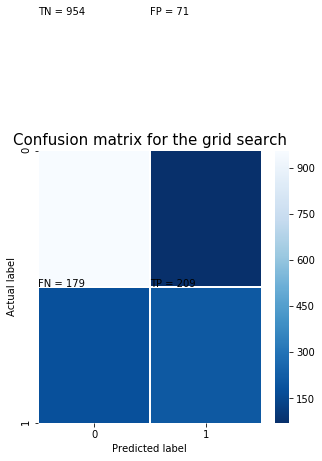

In [157]:
grid_cm = confusion_matrix(y_val, grid_y_pred)
annot_kws = {"ha": 'center',"va": 'center'}


plt.figure(figsize=(5,5))
sns.heatmap(grid_cm, fmt="d", linewidths=.5, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion matrix for the grid search', fontsize = 15)
s = [['TN','FP'], ['FN', 'TP']]

for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(grid_cm[i][j]))
plt.show()

### Feature importance

In [73]:
grid_feature_importances = [(list(X.columns)[i], grid_clf_best.feature_importances_[i]) for i in range(len(list(X.columns)))]
grid_feature_importances.sort(key=itemgetter(1), reverse = True)
plot_importance(grid_feature_importances, 10, 'Grid search')

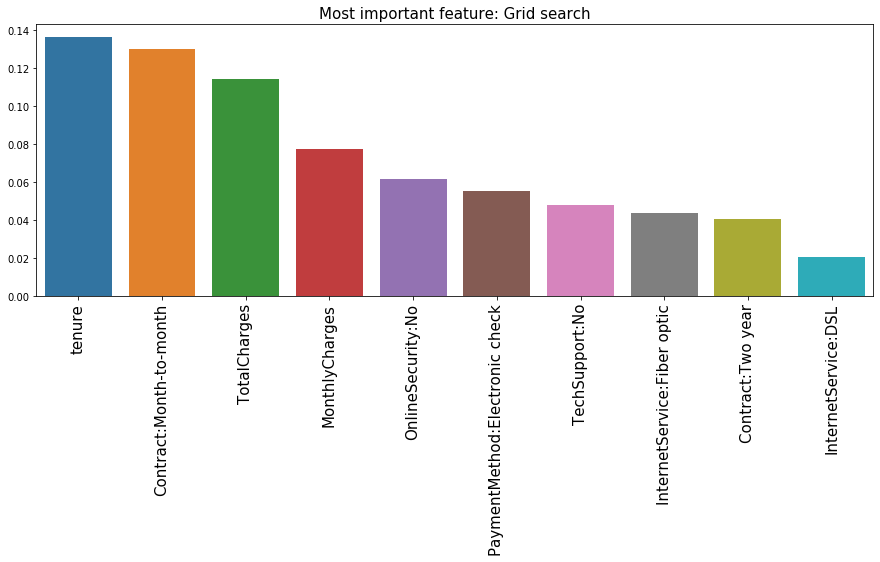

### Feature selection
Let's try to run the model again, but this time selecting only the most impacting features, saving us some work and compare the results

In [144]:
grid_selected_features = [grid_feature_importances[i][0] for i in range(15)]
grid_X_train_sel = X_train[grid_selected_features]
grid_X_val_grid_sel = X_val[grid_selected_features]


In [ ]:
grid_clf.fit(X_train_grid_sel, y_train)

In [153]:
grid_best_score_sel = grid_clf.best_score_
grid_best_parameters_sel = grid_clf.best_params_
grid_best_max_depth_sel = grid_best_parameters.get('max_depth')
grid_best_n_estimators_sel = grid_best_parameters.get('n_estimators')
print('Grid search best_score with selected features: {}'.format(grid_best_score_sel))
print('Grid search best_max_depth with selected features: {}'.format(grid_best_max_depth_sel))
print('Grid search best_n_estimators with selected features: {}'.format(grid_best_n_estimators_sel))

Grid search best_score with selected features: 0.797472859939491
Grid search best_max_depth with selected features: 8
Grid search best_n_estimators with selected features: 200


In [141]:
grid_clf_best_sel = RandomForestClassifier(n_jobs = -1,max_depth = grid_best_max_depth_sel, n_estimators = grid_best_n_estimators_sel )

In [145]:
grid_clf_best_sel.fit(grid_X_train_sel, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [148]:
grid_y_pred_sel = grid_clf_best_sel.predict(grid_X_val_sel)

In [152]:
print("Accuracy:",metrics.accuracy_score(y_val, grid_y_pred_sel))

Accuracy: 0.8089171974522293


# Random Search

After having explored a grid search, we can adopt another approach. Instead of searching for each value, let's give our model more parameters input, but instead let it choose randomly at each iteration one value for each parameter. It will then be evaluated again.

In [46]:
n_estimators = range(10,1000,50)
criterion = ['gini', 'entropy']
max_features = ['sqrt', 'log2', None]
bootstrap = [True,False]
max_depth = range(5,50,10)
min_samples_leaf = range(2,100, 2)
min_samples_split = range(2,100,2)

random_parameters = {'n_estimators':n_estimators, 'max_features':max_features, 'max_depth':max_depth, 'min_samples_leaf':
              min_samples_leaf}


In [47]:
random_clf = RandomizedSearchCV(clf, param_distributions = random_parameters, n_iter = 20, verbose = 3)

In [48]:
random_clf.fit(X_train, y_train)

C:\Users\Yann\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] n_estimators=210, min_samples_leaf=6, max_features=log2, max_depth=45 
[CV]  n_estimators=210, min_samples_leaf=6, max_features=log2, max_depth=45, score=0.797, total=   0.7s
[CV] n_estimators=210, min_samples_leaf=6, max_features=log2, max_depth=45 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  n_estimators=210, min_samples_leaf=6, max_features=log2, max_depth=45, score=0.795, total=   0.6s
[CV] n_estimators=210, min_samples_leaf=6, max_features=log2, max_depth=45 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s


[CV]  n_estimators=210, min_samples_leaf=6, max_features=log2, max_depth=45, score=0.797, total=   0.6s
[CV] n_estimators=410, min_samples_leaf=15, max_features=sqrt, max_depth=15 
[CV]  n_estimators=410, min_samples_leaf=15, max_features=sqrt, max_depth=15, score=0.803, total=   1.2s
[CV] n_estimators=410, min_samples_leaf=15, max_features=sqrt, max_depth=15 
[CV]  n_estimators=410, min_samples_leaf=15, max_features=sqrt, max_depth=15, score=0.799, total=   1.1s
[CV] n_estimators=410, min_samples_leaf=15, max_features=sqrt, max_depth=15 
[CV]  n_estimators=410, min_samples_leaf=15, max_features=sqrt, max_depth=15, score=0.803, total=   1.2s
[CV] n_estimators=710, min_samples_leaf=5, max_features=None, max_depth=15 
[CV]  n_estimators=710, min_samples_leaf=5, max_features=None, max_depth=15, score=0.799, total=   5.8s
[CV] n_estimators=710, min_samples_leaf=5, max_features=None, max_depth=15 
[CV]  n_estimators=710, min_samples_leaf=5, max_features=None, max_depth=15, score=0.792, tota

[CV]  n_estimators=410, min_samples_leaf=4, max_features=sqrt, max_depth=15, score=0.795, total=   1.5s
[CV] n_estimators=410, min_samples_leaf=4, max_features=sqrt, max_depth=15 
[CV]  n_estimators=410, min_samples_leaf=4, max_features=sqrt, max_depth=15, score=0.793, total=   1.4s
[CV] n_estimators=410, min_samples_leaf=4, max_features=sqrt, max_depth=15 
[CV]  n_estimators=410, min_samples_leaf=4, max_features=sqrt, max_depth=15, score=0.801, total=   1.5s
[CV] n_estimators=460, min_samples_leaf=8, max_features=None, max_depth=45 
[CV]  n_estimators=460, min_samples_leaf=8, max_features=None, max_depth=45, score=0.804, total=   4.0s
[CV] n_estimators=460, min_samples_leaf=8, max_features=None, max_depth=45 
[CV]  n_estimators=460, min_samples_leaf=8, max_features=None, max_depth=45, score=0.792, total=   3.9s
[CV] n_estimators=460, min_samples_leaf=8, max_features=None, max_depth=45 
[CV]  n_estimators=460, min_samples_leaf=8, max_features=None, max_depth=45, score=0.791, total=   3

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.8min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs

In [49]:
random_best_score = random_clf.best_score_
print('Random search best_score: {}'.format(random_best_score))
random_best_parameters = random_clf.best_params_

Random search best_score: 0.801388147357181


In [50]:
random_best_parameters

{'n_estimators': 410,
 'min_samples_leaf': 15,
 'max_features': 'sqrt',
 'max_depth': 15}

In [51]:
random_clf_best = RandomForestClassifier(max_depth = 35, max_features = 'sqrt', min_samples_leaf = 9, n_estimators = 250)

In [52]:
random_clf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=35, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [53]:
random_y_pred = random_clf_best.predict(X_val)

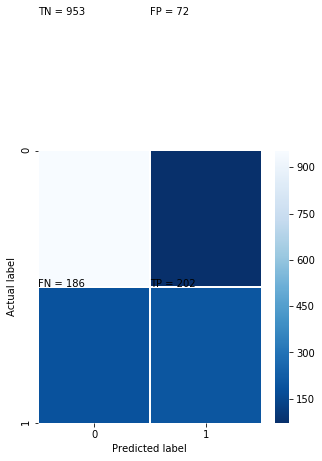

In [54]:
random_cm = confusion_matrix(y_val, random_y_pred)
annot_kws = {"ha": 'center',"va": 'center'}


plt.figure(figsize=(5,5))
sns.heatmap(random_cm, fmt="d", linewidths=.5, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
s = [['TN','FP'], ['FN', 'TP']]

for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(random_cm[i][j]))
plt.show()

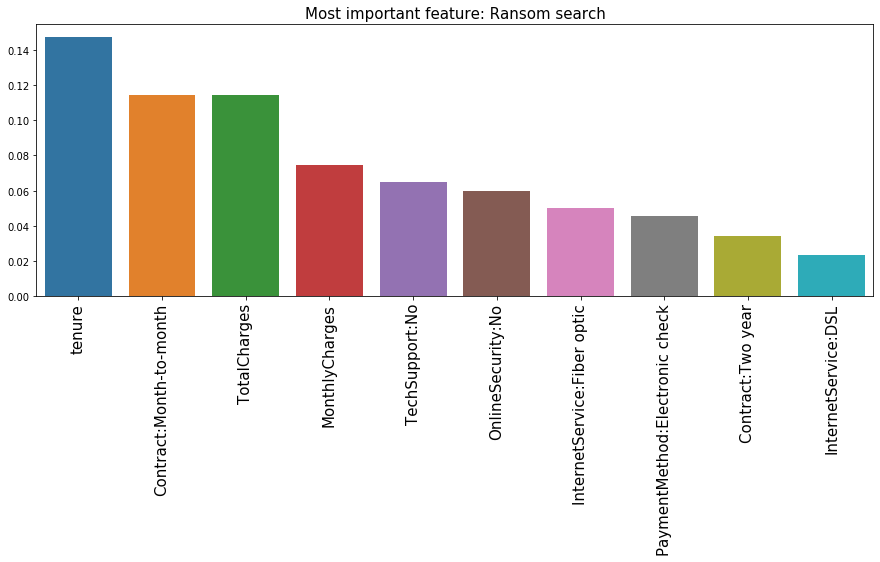

In [121]:
random_feature_importances = [(list(X.columns)[i], random_clf_best.feature_importances_[i]) for i in range(len(list(X.columns)))]
random_feature_importances.sort(key=itemgetter(1), reverse = True)
plot_importance(random_feature_importances, 10, 'Ransom search')

In [37]:
print(classification_report(y_val,random_y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1025
           1       0.74      0.52      0.61       388

    accuracy                           0.82      1413
   macro avg       0.79      0.73      0.75      1413
weighted avg       0.81      0.82      0.81      1413



In [158]:
print("Accuracy:",metrics.accuracy_score(y_val, random_y_pred))

Accuracy: 0.8174097664543525
